In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import math
from scipy.optimize import minimize
from numpy.linalg import inv
import scipy.fft as fft

In [2]:
#--- power-law noise covariance matrix
def create_C(sigma_pl,kappa):
    U = np.identity(N)
    h_prev = 1
    for i in range(1,N):
        h = (i-kappa/2-1)/i * h_prev # Eq. (25)
        for j in range(0,N-i):
            U[j,j+i] = h
        h_prev = h
    U *= sigma_pl # scale noise
    return U.T @ U # Eq. (26)


#--- weighted least-squares
def leastsquares(C,A,y):
    U = np.linalg.cholesky(C).T
    U_inv = inv(U)
    B = U_inv.T @ A
    z = U_inv.T @ y
    x = inv(B.T @ B) @ B.T @ z # Eq. (14)
    #--- variance of the estimated parameters
    C_x = inv(B.T @ B) # Eq. (15)
    #--- Compute log of determinant of C
    ln_det_C = 0.0
    for i in range(0,N):
        ln_det_C += 2*math.log(U[i,i])
    return [x,C_x,ln_det_C]



In [3]:
data = pd.read_csv('TABL.csv')

In [4]:
data.head()

,DATE,NORTH,EAST
0,2015-01-01,167.98,-581.35
1,2015-01-02,167.71,-581.45
2,2015-01-03,167.51,-581.56
3,2015-01-04,168.53,-582.41
4,2015-01-05,169.17,-581.66


In [5]:
date = data.iloc[:,0]
x_north = data.iloc[:,1].values
x_east = data.iloc[:,2].values

In [6]:
len(x_north)

1350

In [7]:
date_ = np.array([])
for i in range(0,len(date)):
    temp = date[i]
    date_temp = datetime.strptime(temp, "%Y-%m-%d")
    date_ = np.append(date_temp, date_)
date_= np.flipud(date_)

In [8]:
time = np.array([])
for i in range(0,len(date)):
    temp = (date_[i]-date_[0]).days
    time = np.append(time,temp)

In [9]:
time = time/365.25

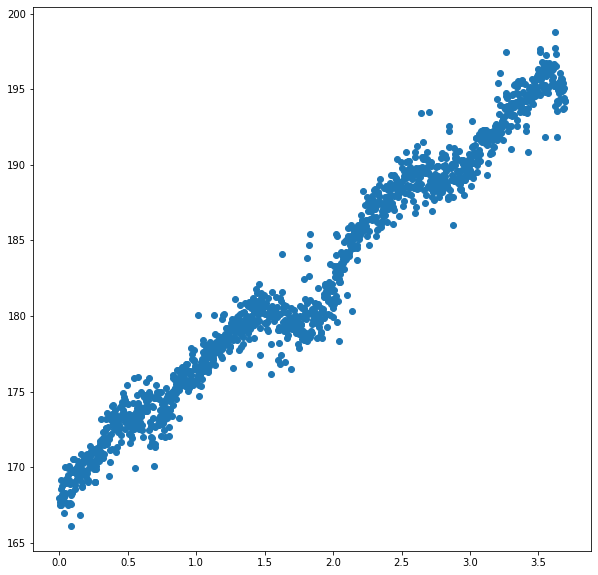

In [10]:
plt.figure(figsize=(10,10))
plt.scatter(time,x_north)
plt.show()

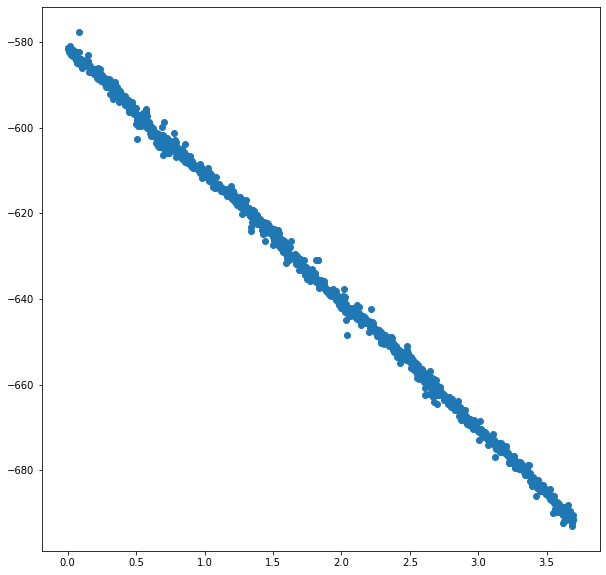

In [11]:
plt.figure(figsize=(10,10))
plt.scatter(time,x_east)
plt.show()

### Applying RANSAC Regression to detect outliers

In [12]:
from sklearn.linear_model import RANSACRegressor
ransac_mod = RANSACRegressor()
ransac_mod.fit(time.reshape(-1,1),x_north.reshape(-1,1))

ransac_mod2 = RANSACRegressor()
ransac_mod2.fit(time.reshape(-1,1),x_east.reshape(-1,1))

RANSACRegressor(base_estimator=None, is_data_valid=None, is_model_valid=None,
                loss='absolute_loss', max_skips=inf, max_trials=100,
                min_samples=None, random_state=None, residual_threshold=None,
                stop_n_inliers=inf, stop_probability=0.99, stop_score=inf)

In [13]:
north = x_north[ransac_mod.inlier_mask_]
east = x_east[ransac_mod2.inlier_mask_]
t_north = time[ransac_mod.inlier_mask_]
t_east = time[ransac_mod2.inlier_mask_]

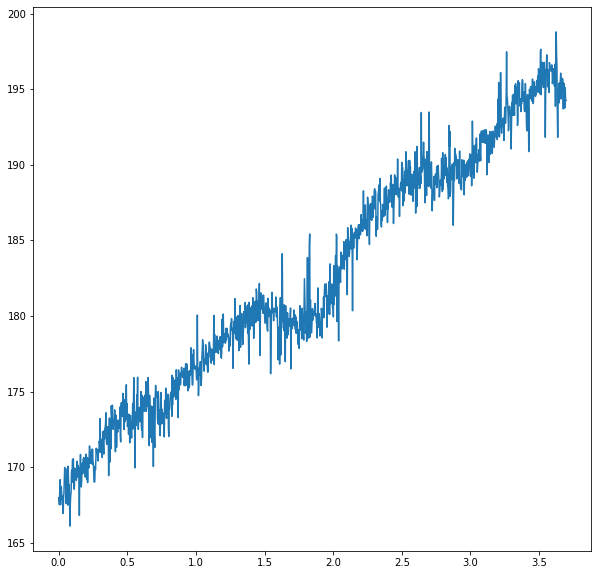

In [14]:
plt.figure(figsize=(10,10))
plt.plot(t_north,north)
plt.show()

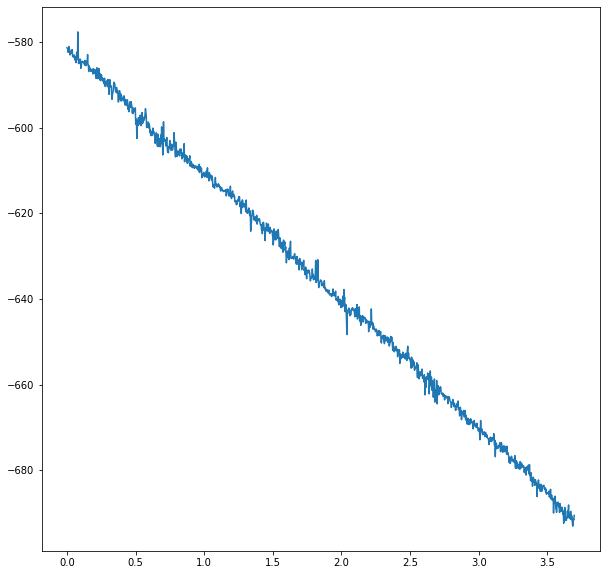

In [15]:
plt.figure(figsize=(10,10))
plt.plot(t_east,east)
plt.show()

#        North

In [16]:
# --- Design Matrix

N = len(t_north)
A = np.empty((N,2))

for i in range(0,N):
    A[i,0] = 1
    A[i,1] = t_north[i]

### Modeling Assuming White Noise

In [17]:
# --- Old White Noise Method

C = np.identity(N)
x = inv(A.T @ inv(C) @ A) @ (A.T @ inv(C) @ north)

north_hat = A @ x
r = north - north_hat #residuals

C_x = np.var(r)* inv(A.T @ inv(C) @ A)

In [18]:
print('White Noise Approximation')
print('a = {0:6.3f} +/- {1:5.3f} mm '.format(x[0],math.sqrt(C_x[0,0])))
print('b = {0:6.3f} +/- {1:5.3f} mm/yr '.format(x[1],math.sqrt(C_x[1,1])))
a1=x[0]
b1=x[1]
white_v_north = b1
white_v_north_unc = math.sqrt(C_x[1,1])

White Noise Approximation
a = 168.761 +/- 0.077 mm 
b =  7.428 +/- 0.036 mm/yr 


### Modeling Using Power Law Distribution

In [19]:
#--- Log-likelihood (with opposite sign)
def log_likelihood(x_noise):
    sigma_pl = x_noise[0]
    kappa = x_noise[1]
    C = create_C(sigma_pl,kappa)
    [x,C_x,ln_det_C] = leastsquares(C,A,north)
    r = north - A @ x # residuals
    #--- Eq. (12)
    logL = -0.5*(N*math.log(2*math.pi) + ln_det_C + r.T @ inv(C) @ r)
    return -logL

x_noise0 = np.array([1,1]) # sigma_pl and kappa guesses
res = minimize(log_likelihood, x_noise0, \
method='nelder-mead', options={'xatol':0.01})
print('sigma_pl={0:6.3f}, kappa={1:6.3f}'.format(res.x[0],res.x[1]))

sigma_pl= 1.058, kappa=-0.698


In [20]:
#--- The correct noise covariance matrix
sigma_pl = res.x[0]
kappa = res.x[1]
C = create_C(sigma_pl,kappa)
[x,C_x,ln_det_C] = leastsquares(C,A,north)
print('Correct Flicker noise')
print('a = {0:6.3f} +/- {1:5.3f} mm'.format(x[0],\
math.sqrt(C_x[0,0])))
print('b = {0:6.3f} +/- {1:5.3f} mm/yr'.format(x[1],\
math.sqrt(C_x[1,1])))
a2= x[0]
b2=x[1]
power_v_north = b2
power_v_north_unc = math.sqrt(C_x[1,1])
kappa_north = res.x[1]
sigma_north = res.x[0]

Correct Flicker noise
a = 168.579 +/- 0.366 mm
b =  7.464 +/- 0.174 mm/yr


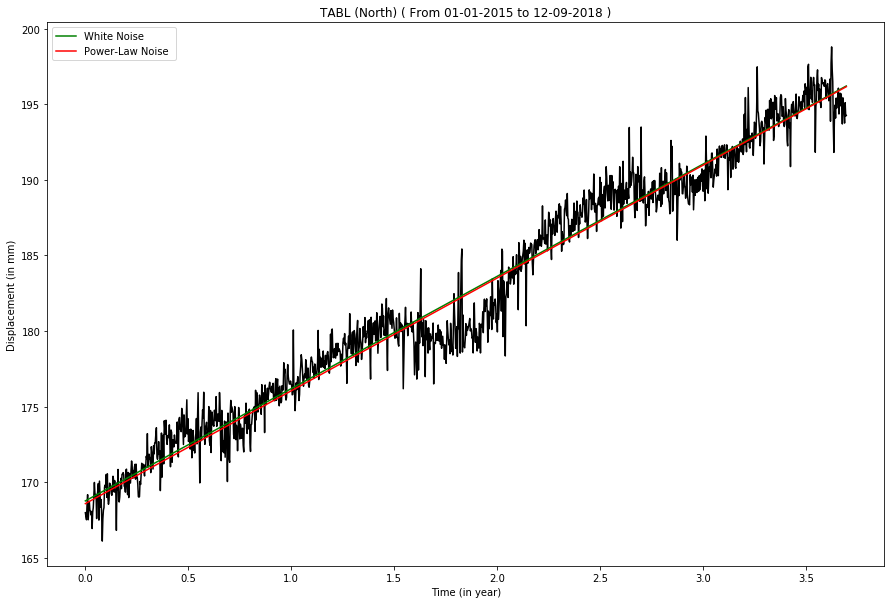

In [21]:
plt.figure(figsize=(15,10))
p1 = plt.plot(t_north, north, color = 'black')
p3 = plt.plot(t_north,a1+b1*t_north,color='green',label='White Noise ')
p4 = plt.plot(t_north,a2+b2*t_north,color='red',label='Power-Law Noise ')
plt.legend()
plt.xlabel('Time (in year)')
plt.ylabel('Displacement (in mm)')
plt.title('TABL (North) ( From 01-01-2015 to 12-09-2018 )')
plt.savefig('TABL-North')
plt.show()

In [22]:
res_north = north-A@x

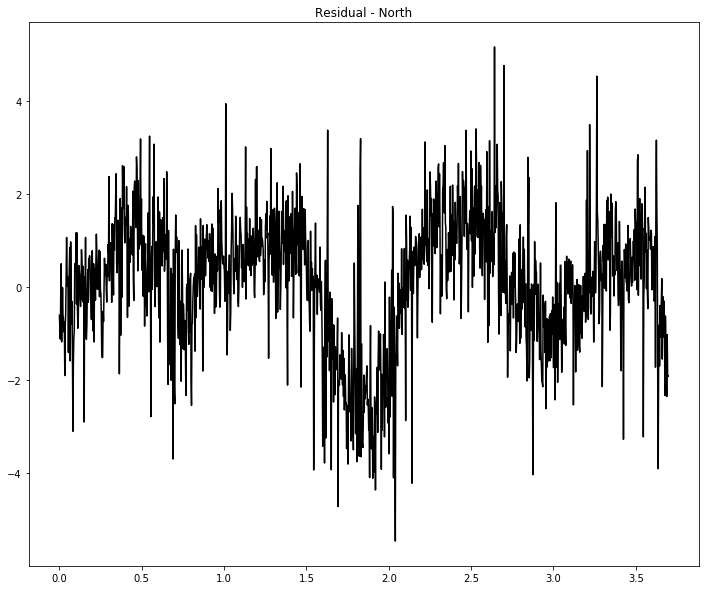

In [23]:
plt.figure(figsize=(12,10))
p1 = plt.plot(t_north, res_north, color = 'black')
plt.title('Residual - North')
plt.show()

# East

In [24]:
# --- Design Matrix

N = len(t_east)
A = np.empty((N,2))

for i in range(0,N):
    A[i,0] = 1
    A[i,1] = t_east[i]

### Modeling Assuming White Noise

In [25]:
# --- Old White Noise Method

C = np.identity(N)
x = inv(A.T @ inv(C) @ A) @ (A.T @ inv(C) @ east)

east_hat = A @ x
r = east - east_hat #residuals

C_x = np.var(r)* inv(A.T @ inv(C) @ A)

In [26]:
print('White Noise Approximation')
print('a = {0:6.3f} +/- {1:5.3f} mm '.format(x[0],math.sqrt(C_x[0,0])))
print('b = {0:6.3f} +/- {1:5.3f} mm/yr '.format(x[1],math.sqrt(C_x[1,1])))
a1=x[0]
b1=x[1]
white_v_east = b1
white_v_east_unc = math.sqrt(C_x[1,1])

White Noise Approximation
a = -581.187 +/- 0.062 mm 
b = -29.649 +/- 0.029 mm/yr 


### Modeling Using Power Law Distribution

In [27]:
#--- Log-likelihood (with opposite sign)
def log_likelihood(x_noise):
    sigma_pl = x_noise[0]
    kappa = x_noise[1]
    C = create_C(sigma_pl,kappa)
    [x,C_x,ln_det_C] = leastsquares(C,A,east)
    r = east - A @ x # residuals
    
    logL = -0.5*(N*math.log(2*math.pi) + ln_det_C + r.T @ inv(C) @ r)
    return -logL

x_noise0 = np.array([1,1]) # sigma_pl and kappa guesses
res = minimize(log_likelihood, x_noise0, \
method='nelder-mead', options={'xatol':0.01})
print('sigma_pl={0:6.3f}, kappa={1:6.3f}'.format(res.x[0],res.x[1]))

sigma_pl= 0.985, kappa=-0.594


In [28]:
#--- The correct noise covariance matrix
sigma_pl = res.x[0]
kappa = res.x[1]
C = create_C(sigma_pl,kappa)
[x,C_x,ln_det_C] = leastsquares(C,A,east)
print('Correct noise')
print('a = {0:6.3f} +/- {1:5.3f} mm'.format(x[0],\
math.sqrt(C_x[0,0])))
print('b = {0:6.3f} +/- {1:5.3f} mm/yr'.format(x[1],\
math.sqrt(C_x[1,1])))
a2=x[0]
b2=x[1]
power_v_east = b2
power_v_east_unc = math.sqrt(C_x[1,1])
kappa_east = res.x[1]
sigma_east = res.x[0]

Correct noise
a = -581.215 +/- 0.268 mm
b = -29.685 +/- 0.123 mm/yr


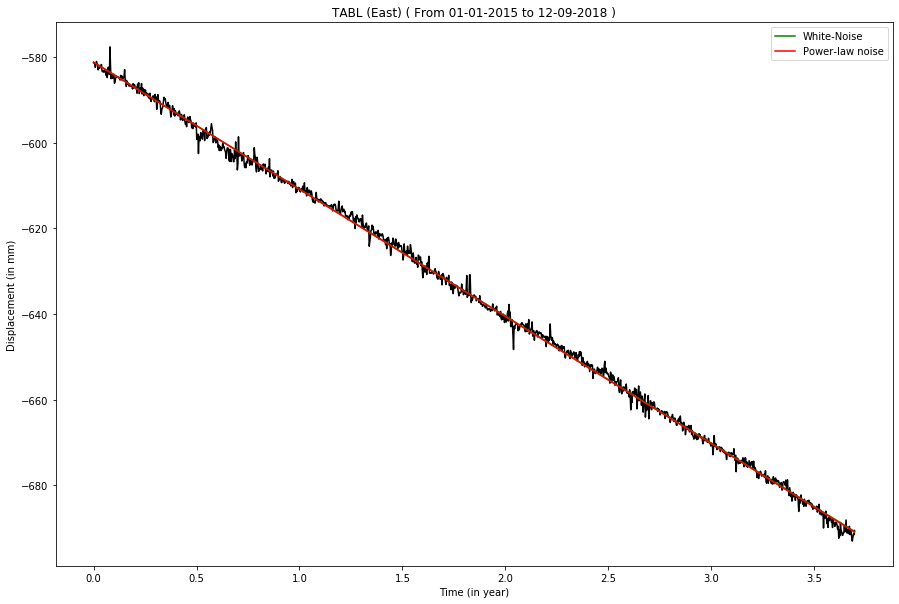

In [29]:
plt.figure(figsize=(15,10))
p1 = plt.plot(t_east, east, color = 'black')
p3 = plt.plot(t_east,a1+b1*t_east,color='green',label='White-Noise')
p4 = plt.plot(t_east,a2+b2*t_east,color='red',label='Power-law noise')
plt.legend()

plt.xlabel('Time (in year)')
plt.ylabel('Displacement (in mm)')
plt.title('TABL (East) ( From 01-01-2015 to 12-09-2018 )')
plt.savefig('TABL-East')
plt.show()

In [30]:
res_east = east-A@x

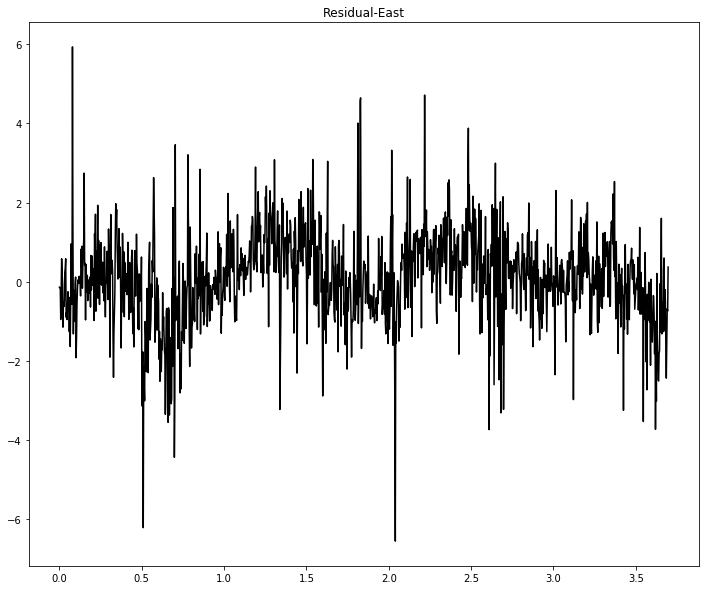

In [36]:
plt.figure(figsize=(12,10))
p1 = plt.plot(t_east, res_east, color = 'black')
plt.title('Residual-East')
plt.show()

In [37]:
##### print('White Noise')
print('')
print('        NORTH        ')
print('V_north -->',  white_v_north)
print('V_north_unc -->',  white_v_north_unc)
print('        EAST        ')
print('V_east -->',  white_v_east)
print('V_east_unc -->',  white_v_east_unc)
print('')

print('Power Law Noise')

print('')
print('        NORTH        ')

print('power_v_north -->', power_v_north)
print('power_v_north_unc -->',power_v_north_unc)
print('kappa_north -->',kappa_north)
print('sigma_north -->', sigma_north)
print('')
print('        EAST        ')
print('power_v_east -->', power_v_east)
print('power_v_east_unc -->',power_v_east_unc)
print('kappa_east -->',kappa_east)
print('sigma_east -->', sigma_east)


        NORTH        
V_north --> 7.42766564617807
V_north_unc --> 0.03585161477562314
        EAST        
V_east --> -29.649444787065022
V_east_unc --> 0.028854480321670855

Power Law Noise

        NORTH        
power_v_north --> 7.463817095589755
power_v_north_unc --> 0.17398549436831084
kappa_north --> -0.6977852593976112
sigma_north --> 1.057926981824052

        EAST        
power_v_east --> -29.684855620970694
power_v_east_unc --> 0.12322496076982735
kappa_east --> -0.5942390283938292
sigma_east --> 0.9848521449795763


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, Slope, Intercept]
Sampling 2 chains, 0 divergences: 100%|██████████| 11000/11000 [00:17<00:00, 645.46draws/s]
The acceptance probability does not match the target. It is 0.977806543268972, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9902836614652735, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, Slope, Intercept]
Sampling 2 chains, 0 divergences: 100%|██████████| 11000/11000 [00:15<00:00, 693.17draws/s]
The acceptance probability does not match the target. It is 0.982589667321316, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9883074057021288, but should be close to 0.8. Try to increase the number of t

V_east =  -29.657
V_east_unc =  0.029
V_north =  7.432
V_north_unc =  0.036


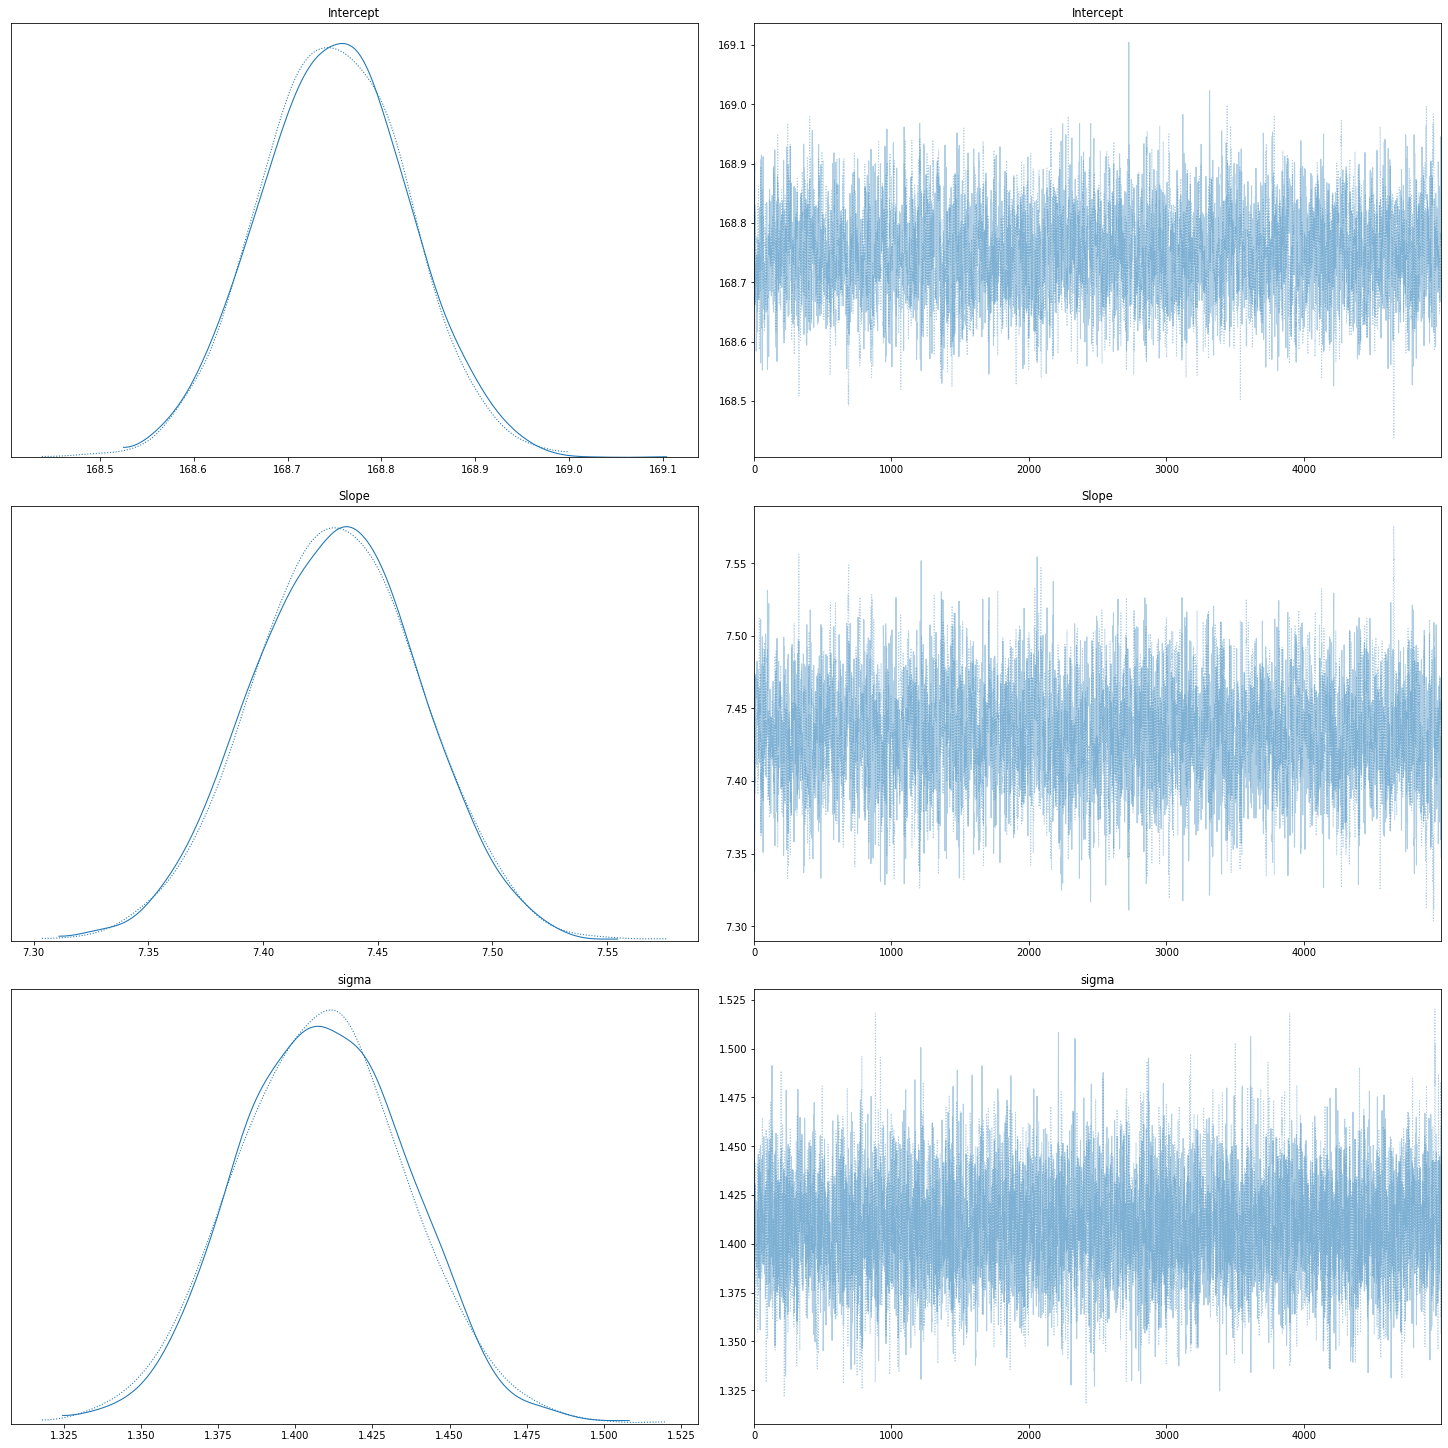

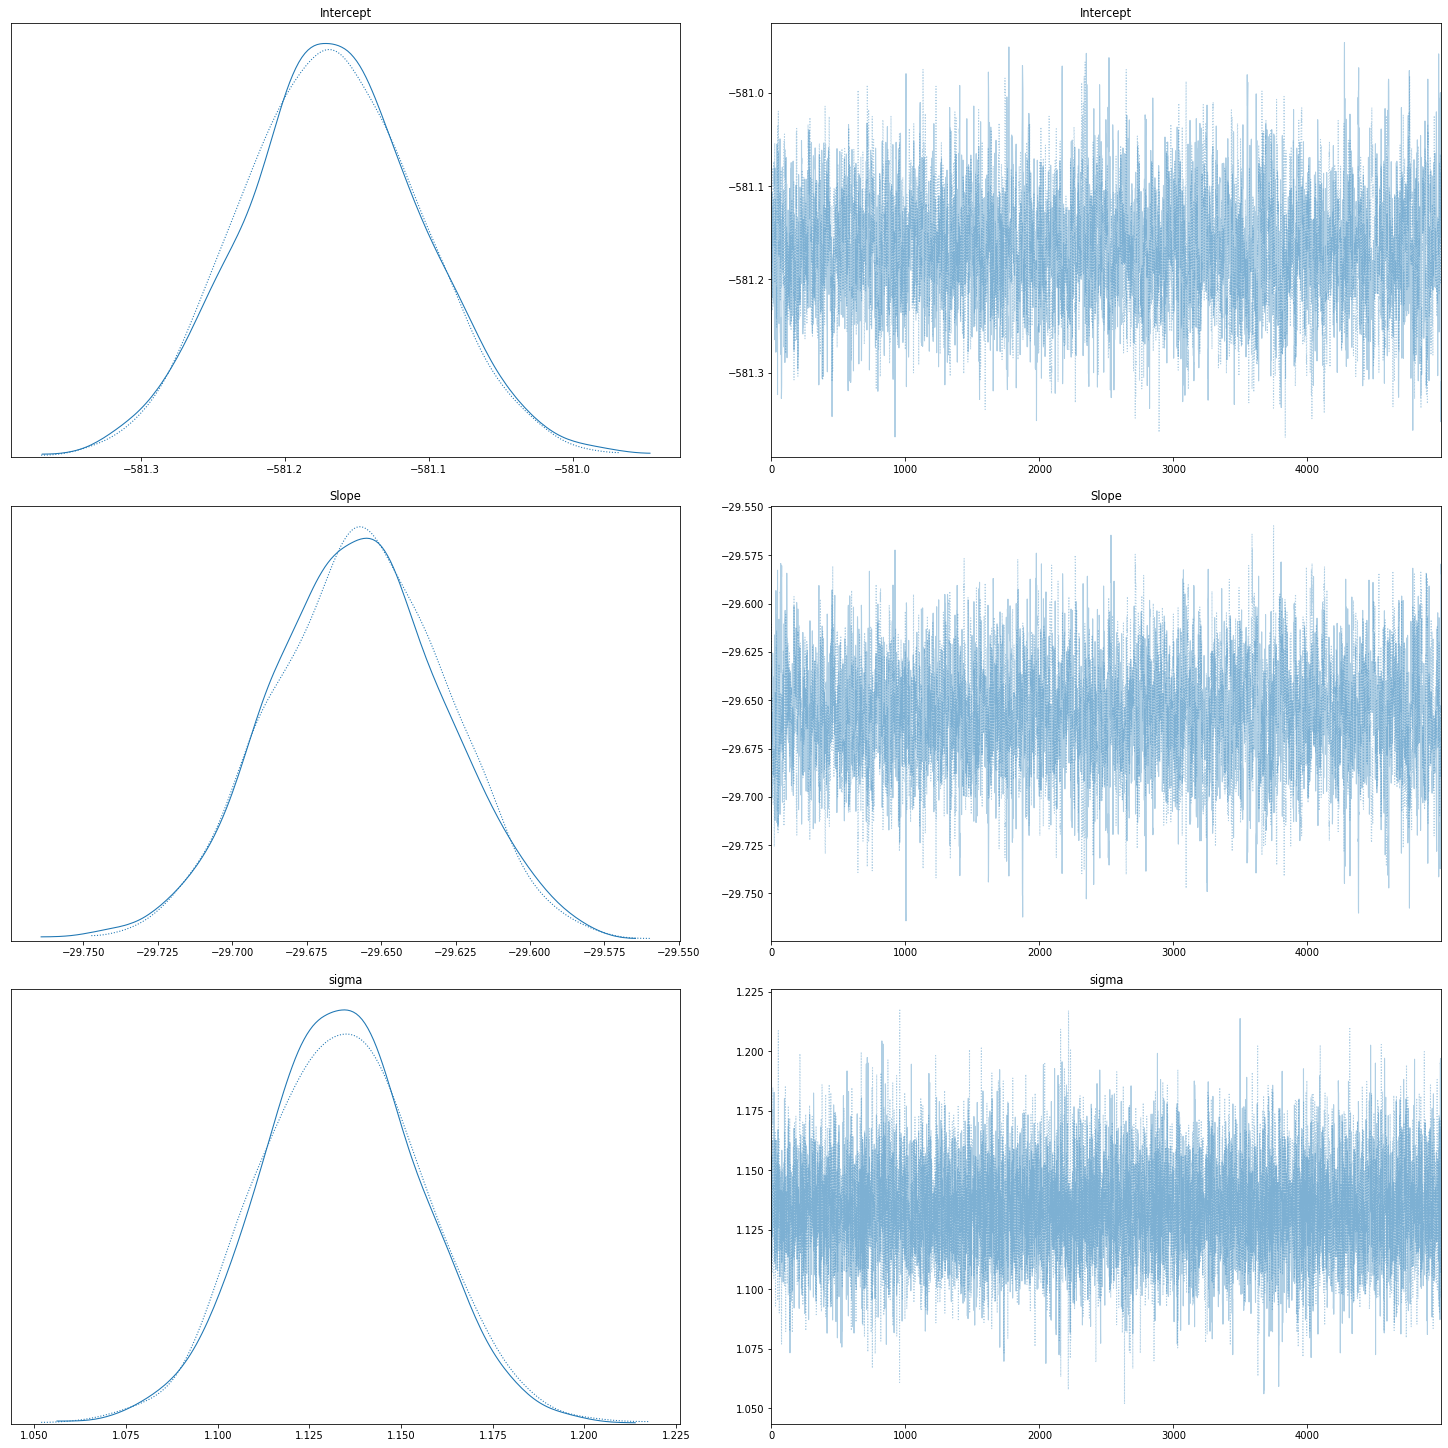

In [38]:
# Markov Chain Monte Carlo Method

import scipy
import pymc3 as pm


x = t_north
y = north

with pm.Model() as linear_model:
    #Intercept
    intercept = pm.Normal('Intercept' , mu = 0, sd = 10)
    
    #Slope
    slope =  pm.Normal('Slope' , mu =0,  sd = 10)
    
    #Standard Deviation
    sigma  = pm.HalfNormal('sigma', sd = 10)
    
    #Estimation of Mean
    mean = intercept + slope*x
    
    #observed values
    
    Y_obs = pm.Normal('Y_obs', mu = mean, sd = sigma, observed = y)
    
    #sampler
    step = pm.NUTS()
    
    #Posterior Distribution
    linear_trace = pm.sample(5000,step)
    

pm.traceplot(linear_trace, figsize = (20, 20))
plt.savefig('TABL - North (MCMC)')

summary = pm.summary(linear_trace)
v_north = summary.iloc[1,0]
v_north_unc =  summary.iloc[1,1]



x = t_east
y = east

with pm.Model() as linear_model:
    #Intercept
    intercept = pm.Normal('Intercept' , mu = 0, sd = 10)
    
    #Slope
    slope =  pm.Normal('Slope' , mu =0,  sd = 10)
    
    #Standard Deviation
    sigma  = pm.HalfNormal('sigma', sd = 10)
    
    #Estimation of Mean
    mean = intercept + slope*x
    
    #observed values
    
    Y_obs = pm.Normal('Y_obs', mu = mean, sd = sigma, observed = y)
    
    #sampler
    step = pm.NUTS()
    
    #Posterior Distribution
    linear_trace = pm.sample(5000,step)
    

pm.traceplot(linear_trace, figsize = (20, 20))
plt.savefig('TABL - East (MCMC)')

summary = pm.summary(linear_trace)
v_east = summary.iloc[1,0]
v_east_unc =  summary.iloc[1,1]

print('V_east = ', v_east)
print('V_east_unc = ', v_east_unc)
print('V_north = ', v_north)
print('V_north_unc = ', v_north_unc)